   # Проверка гипотез и анализ результатов А/В теста

**Описание данных**

Данные для первой части

**Файл hypothesis.csv.** 
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

**Файл orders.csv.** 
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Файл visitors.csv.** 
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

##  Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import scipy.stats as stats
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
visitors = pd.read_csv('/datasets/visitors.csv')
orders = pd.read_csv('/datasets/orders.csv')
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
# прочитаем информацию 
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [4]:
# преобразуем даты
visitors['date'] = pd.to_datetime(visitors['date'])

visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
print(visitors['group'].unique())

['A' 'B']


In [6]:
print('Дата первого посещения :', min(visitors['date'].dt.date))
print('Дата последнего:', max(visitors['date'].dt.date))

Дата первого посещения : 2019-08-01
Дата последнего: 2019-08-31


In [7]:
# посмотрим информацию 
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
# переименуем столбцы
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

# преобразуем даты
orders['date'] = pd.to_datetime(orders['date'])

orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
# проверим на дубликаты
orders.duplicated().sum()

0

In [10]:
print(orders['group'].unique())

['B' 'A']


In [11]:
print('Дата первого заказа:', min(orders['date'].dt.date))
print('Дата последнего заказа :', max(orders['date'].dt.date))

Дата первого заказа: 2019-08-01
Дата последнего заказа : 2019-08-31


In [12]:
#Определим количество пользователей в каждой группе. И посмотрим есть ли пользователи, входящие в обе группы.
orders_in_group = (
    orders.groupby('group')
    .agg({'visitor_id': ['nunique', 'count']})
)
orders_in_group.columns = ['unique_group', 'group_size']
orders_in_group['both_groups'] = orders_in_group['group_size'] - orders_in_group['unique_group']
orders_in_group

,unique_group,group_size,both_groups
group,,,
A,503,557,54
B,586,640,54


In [13]:
# информация по датафрейму
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [14]:
# приведем названия столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [15]:
# проверка дубликатов строк
hypothesis.duplicated().sum()

0

In [16]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


**Выводы**

Подготовили данные к анализу.
Переименовали столбцы,провели замену типа данных,проверили на дубликаты.

##  Приоритизация гипотез.

In [17]:
pd.options.display.max_colwidth = 210
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis.sort_values(by='ICE', ascending=False).round()


,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


Наиболее перспективные гипотезы по ICE:

- 8 Запустить акцию, дающую скидку на товар в день рождения;

- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

In [18]:
pd.options.display.max_colwidth = 210
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis.sort_values('RICE', ascending=False).round()

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.0,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.0,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.0,16.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.0,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.0,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


Наиболее перспективные гипотезы по RICE:

- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- 2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- 6 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Приоретизация по разным фреймворкам отличается.
Если в ICE на первом месте 8 гипотезa, то в RICE эта гипотеза на пятом месте, а на первом 7, хотя в первом расчетё она на 3 месте.
Так получается потому что во фреймворке RICE задействован параметр reach (охват пользователей). 

## Анализ A/B-теста

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [19]:
# создаем массив уникальных пар значений дат и групп A/B-теста
dates_groups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply( \
                        lambda x: orders[np.logical_and(orders['date'] <= x['date'], \
                        orders['group'] == x['group'])] \
                        .agg({ \
                              'date' : 'max', \
                              'group' : 'max', \
                              'transaction_id' : 'nunique', \
                              'visitor_id' : 'nunique', \
                              'revenue' : 'sum'}), \
                        axis=1).sort_values(by=['date','group']) 

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply( \
                        lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], \
                        visitors['group'] == x['group'])] \
                        .agg({ \
                              'date' : 'max', \
                              'group' : 'max', \
                              'visitors' : 'sum'}), \
                        axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitor_id']

In [20]:
display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitor_id
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [21]:
# Кумулятивное количество заказов и кумулятивная выручка по дням в группе А и группе B
cumulative_revenue_A = cumulative_data.query('group == "A"')[['date', 'revenue', 'orders']]
cumulative_revenue_B = cumulative_data.query('group == "B"')[['date', 'revenue', 'orders']]

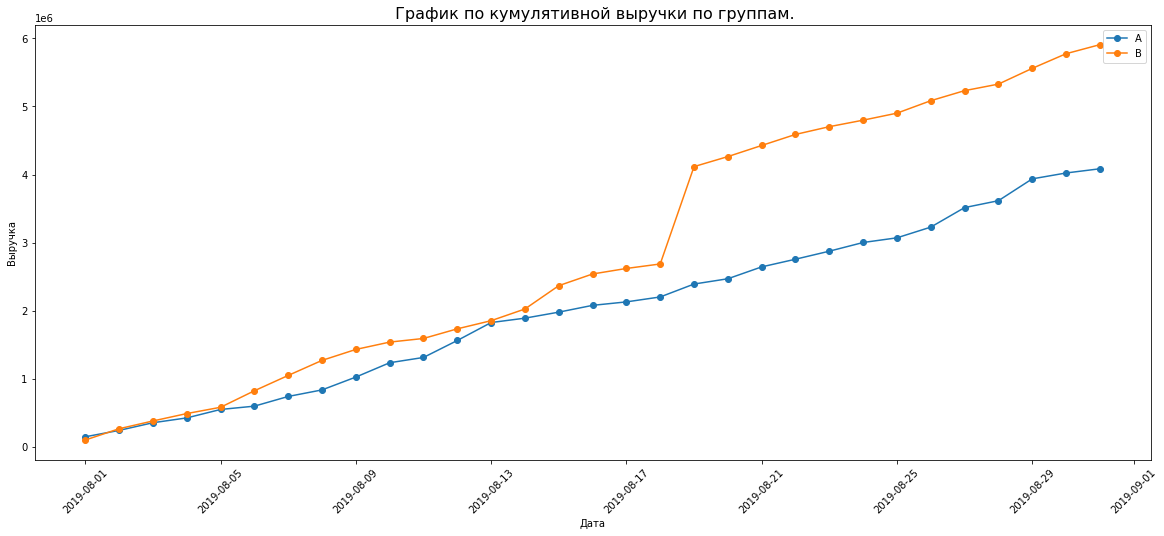

In [22]:
# Строим график выручки группы А
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)

plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A', marker='o')

# Строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B', marker='o')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title(' График по кумулятивной выручки по группам.', fontsize=16)
plt.legend()
plt.show()

 **Выводы**

Выручка почти равномерно увеличивается в течение всего теста в обеих группах.

Однако график выручки группы B c 18.09.19 по 19.09.19 резко вырос. Это может говорить о всплеске числа заказов, либо о появлении очень дорогих заказов в этот конкретный период.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения


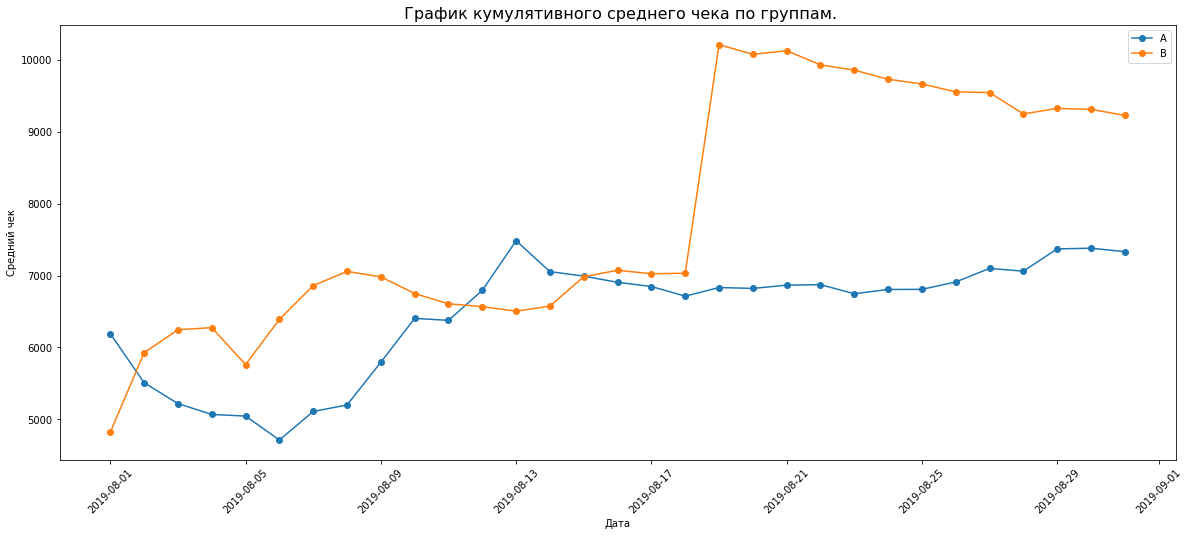

In [23]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]


plt.figure(figsize=(20,8))
plt.xticks(rotation=45)

# Строим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A', 
         marker='o')
# Строим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B',
         marker='o')

plt.ylabel("Средний чек")
plt.xlabel('Дата')
plt.title(' График кумулятивного среднего чека по группам.', fontsize=16)
plt.legend()
plt.show()

 **Выводы**
 
Средний чек в группе А после падения и резкого роста стал более равномерным,а в группе B после значительного скачка начинает медленно сокращаться.Возможно, это связано с крупными покупками. 


### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения

In [24]:
# собираем данные в одном датафрейме
merge_cumulative_revenue = cumulative_revenue_A.merge(
    cumulative_revenue_B, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A','B']
)

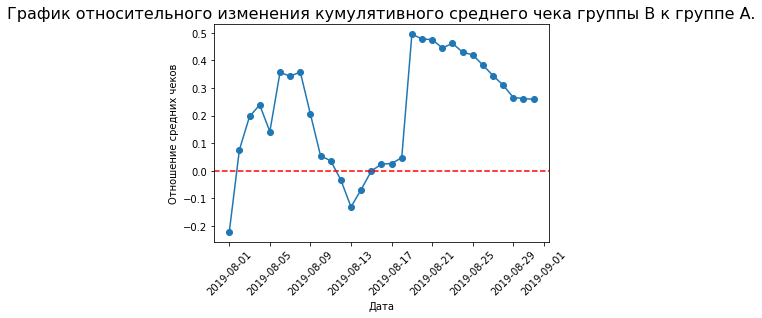

In [25]:
# cтроим отношение средних чеков
plt.plot(merge_cumulative_revenue['date'], (merge_cumulative_revenue['revenueB']/merge_cumulative_revenue['ordersB'])/
                                          (merge_cumulative_revenue['revenueA']/merge_cumulative_revenue['ordersA'])-1,
                                           marker='o')
# добавляем ось X
plt.axhline(y=0, color='red', linestyle='--') 
plt.ylabel("Отношение средних чеков")
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A.', fontsize=16)
plt.xticks(rotation=45)
plt.show()

Исходя из графика видно, что результаты теста резко менялись. 6 августа был резкий скачок, далее спад вплоть до 13 августа и самый высокий скачок снова отмечается 18-19 августа. Видимо именно в это время были совершеные аномальные заказы.

### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

In [26]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitor_id']

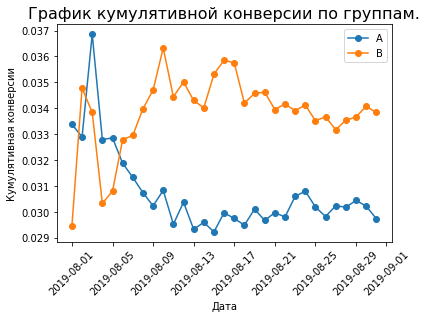

In [27]:
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A', marker='o')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B', marker='o')
plt.ylabel("Кумулятивная конверсии")
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии по группам.', fontsize=16)
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Выводы**

В начале теста значения не стабильны и сильно колеблются вокруг одного значения. Ближе к концу теста данные стабилизируются, конверсия у группы B выше.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения

In [28]:
# собираем данные в одном датафрейме
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(
    cumulative_data_B[['date','conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['_A', '_B'])

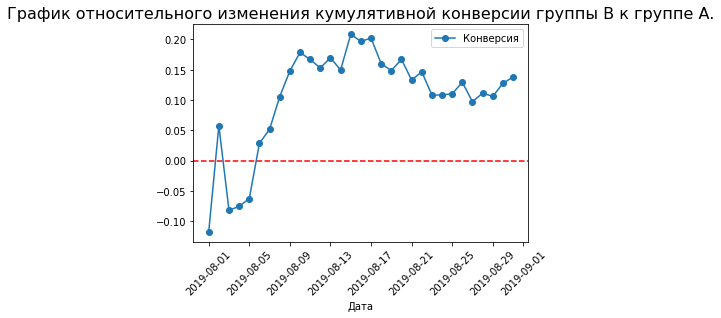

In [29]:
# строим график
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversion_B']/merged_cumulative_conversions['conversion_A']-1,
         label="Конверсия", marker='o')
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A.', fontsize=16)
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.show()

**Вывод**

В начале теста группа B проигрывала группе A , но с 06.08.2019 вырвалась вперёд и предвосходила группу A приблизительно на 15%.С 21.08.2019 происходит небольшая стабилизация результатов.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения

In [30]:
# Создадим таблицу с количеством заказов по пользователям
orders_by_visitors = (orders
                       .drop(['group', 'revenue', 'date'], axis=1)
                       .groupby('visitor_id', as_index=False)
                       .agg({'transaction_id': pd.Series.nunique})
                     )
orders_by_visitors.columns = ['visitor_id', 'orders']

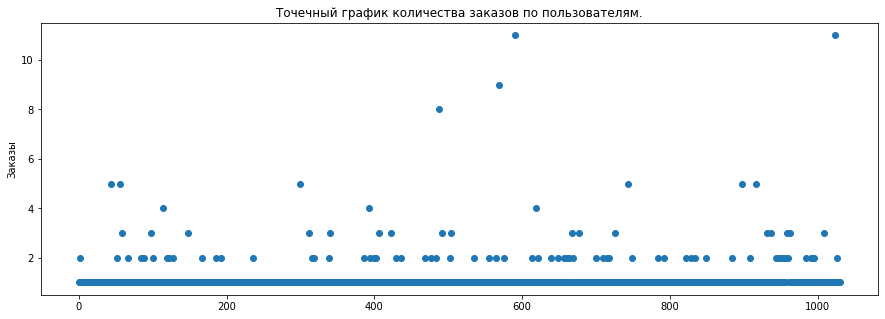

In [31]:
# Построим точечный график количества заказов по пользователям.
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0,len(orders_by_visitors)))

plt.figure(figsize=(15,5))
plt.scatter(x_values, orders_by_visitors['orders'])
plt.ylabel('Заказы')
plt.title('Точечный график количества заказов по пользователям.', fontsize=12)
plt.show()


**Выводы**

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-5 заказами тоже значительна. Также есть пользователи, которые совершали 8, 9 и 11 заказов.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей

In [32]:
# Посчитаем 95-й и 99-й выборочные перцентили количества заказов по пользователям 
print(np.percentile(orders_by_visitors['orders'], [95, 99]))

[2. 4.]


**Вывод**

Не более 5% пользователей оформляли больше чем 2 заказа;
1% пользователей заказывали более 4 раз;
Выберем 4 заказа на одного пользователя за нижнюю границу числа заказов.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения

In [33]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Text(0, 0.5, 'Стоимость заказов на пользователя')

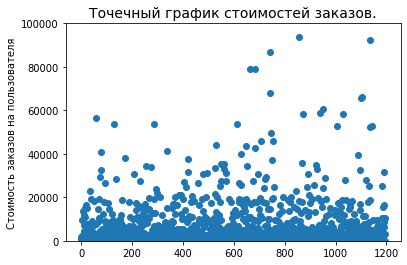

In [34]:
# серия из чисел от 0 до количества наблюдений в orders
x_values = pd.Series(range(0, len(orders['revenue'])))
#строим точечный график 
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100000)
plt.title('Точечный график стоимостей заказов.', fontsize=14)
plt.ylabel('Стоимость заказов на пользователя')

**Выводы**

Среднее число заказов на сумму около 20 000 рублей. Заказ на 1 294 500 рублей в интернет-магазине выглядит весьма аномально.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов

In [35]:
# Посчитаем 95-й и 99-й выборочные перцентили тоимости заказов методом np.percentile()
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


**Выводы**
Не более, чем 5% заказов чек дороже 28 000 рублей. И не более чем 1% заказов – дороже 58 233 рублей.

Границу для определения аномальных заказов, выберем 28 000 рублей.

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

In [36]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date','visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date':'max',
         'visitors_per_date_A':'sum'}
    ), axis=1
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date','visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date':'max',
         'visitors_per_date_B':'sum'}
    ), axis=1
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

In [37]:
orders_A_daily = orders[orders['group'] == 'A'][['date',
                                                 'transaction_id',
                                                 'visitor_id',
                                                 'revenue']].groupby(
    'date', as_index=False).agg(
    {'transaction_id': pd.Series.nunique, 
     'revenue': 'sum'})
orders_A_daily.columns = ['date', 'order_per_date_A', 'revenue_per_date_A']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date':'max',
         'order_per_date_A':'sum',
         'revenue_per_date_A':'sum'}), axis=1).sort_values('date')
orders_A_cummulative.columns = ['date',
                                'orders_cummulative_A',
                                'revenue_cummulative_A',]

orders_B_daily = orders[orders['group'] == 'B'][['date',
                                                 'transaction_id',
                                                 'visitor_id',
                                                 'revenue']].groupby(
    'date', as_index=False).agg(
    {'transaction_id': pd.Series.nunique, 
     'revenue': 'sum'})
orders_B_daily.columns = ['date', 'order_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date':'max',
         'order_per_date_B':'sum',
         'revenue_per_date_B':'sum'}), axis=1).sort_values('date')
orders_B_cummulative.columns = ['date',
                                'orders_cummulative_B',
                                'revenue_cummulative_B',]

In [38]:
## Соединим все таблицы с полученными значениями
data = orders_A_daily.merge(
    orders_B_daily, left_on='date', right_on='date', how='left').merge(
    orders_A_cummulative, left_on='date', right_on='date', how='left').merge(
    orders_B_cummulative, left_on='date', right_on='date', how='left').merge(
    visitors_A_daily, left_on='date', right_on='date', how='left').merge(
    visitors_B_daily, left_on='date', right_on='date', how='left').merge(
    visitors_A_cummulative, left_on='date', right_on='date', how='left').merge(
    visitors_B_cummulative, left_on='date', right_on='date', how='left')
data.head()

,date,order_per_date_A,revenue_per_date_A,order_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [39]:
# Число совершённых заказов для пользователей, которые заказывали хотя бы 1 раз, в каждой группе 
orders_by_visitors_A = orders[orders['group'] == 'A'].groupby(
    'visitor_id', as_index=False).agg(
    {'transaction_id':pd.Series.nunique}
)
orders_by_visitors_A.columns = ['visitor_id','orders']

orders_by_visitors_B = orders[orders['group'] == 'B'].groupby(
    'visitor_id', as_index=False).agg(
    {'transaction_id':pd.Series.nunique}
)
orders_by_visitors_B.columns = ['visitor_id','orders']

In [40]:
# Объявим переменные sample_A и sample_B, в которых пользователям из разных групп будет соответствовать количество заказов. 
sample_A = pd.concat([orders_by_visitors_A['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_A'].sum() - 
                    len(orders_by_visitors_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_visitors_B['orders'], pd.Series(0, index=np.arange(data['visitors_per_date_B'].sum() - 
                    len(orders_by_visitors_B['orders'])), name='orders')],axis=0)

In [41]:
#Применим тест Манна-Уитни:
print('Значение p-value для конверсий:: {0:.3f}'.format(stats.mannwhitneyu(sample_A, sample_B)[1]))
print('Относительный прирост конверсии группы B: {0:.3f}'.format(sample_B.mean()/sample_A.mean()-1)) 

Значение p-value для конверсий:: 0.017
Относительный прирост конверсии группы B: 0.138


**Сформулируем нулевую и альтернативную гипотезы:**

**Нулевая гипотеза Ho:** Нет статистически значимых различий по конверсии между группами А и В по «сырым» данным

**Альтернативная гипотеза H1:** Есть статистически значимое различие по конверсии между группами А и В по «сырым» даннымb

In [42]:
# Выполним проверку гипотезы.

alpha = 0.05 # критический уровень статистической значимости для формулирования двусторонних гипотез
results = stats.mannwhitneyu(sample_A, sample_B)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.016792355056752608
Отвергаем нулевую гипотезу


Анализ "сырых данных" показывает, что в конверсии между группами есть статистически значимые различия. 
Относительный прирост группы B к конверсии группы А равен 13,8% - принимаем Альтернативную гипотезу (H1)

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

**Сформулируем нулевую и альтернативную гипотезы:**

**Нулевая гипотеза:** Но-различий в среднем чеке между группами по «сырым» данным нет.

**Альтернативная гипотеза:** Н1-различия в среднем чеке между группами по «сырым» данным есть.

In [43]:
# Воспользуемся критерием Манна-Уитни
alpha = 0.05
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем Ho: разница статистически значима")
else:
    print("Не получилось отвергнуть Ho")

p-значение:  0.7292909855432458
Не получилось отвергнуть Ho


**Вывод**

Анализ "сырых данных" показывает, что в средних чеках групп нет статистически значимых различий. 

### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

In [44]:
# Срезы данных для аномальных пользователей
visitors_many_orders = pd.concat([orders_by_visitors_A.query('orders >4 ')['visitor_id'], 
                                  orders_by_visitors_B.query('orders > 4')['visitor_id']], axis = 0)
visitors_expensive_orders = orders.query('revenue >=28000 ')['visitor_id']

# Число аномальных пользователей
abnormalvisits = pd.concat([visitors_many_orders, visitors_expensive_orders], axis = 0).drop_duplicates().sort_values()
len(abnormalvisits)

59

In [45]:
#  Сначала подготовим выборки количества заказов по пользователям по группам теста:
sample_A_cleared = pd.concat([orders_by_visitors_A[np.logical_not(orders_by_visitors_A['visitor_id'].isin(abnormalvisits))]['orders'],pd.Series(0,
                         index=np.arange(data['visitors_per_date_A'].sum() - len(orders_by_visitors_A['orders'])),name='orders')],axis=0)

sample_B_cleared = pd.concat([orders_by_visitors_B[np.logical_not(orders_by_visitors_B['visitor_id'].isin(abnormalvisits))]['orders'],pd.Series(0,
                         index=np.arange(data['visitors_per_date_B'].sum() - len(orders_by_visitors_B['orders'])),name='orders')],axis=0)

# Применим статистический критерий Манна-Уитни к полученным выборкам:
print("p-value, после очистки данных: {0:.3f}".format(stats.mannwhitneyu(sample_A_cleared, sample_B_cleared)[1]))
print("Относительный прирост конверсии группы B по отношению к группе A после очистки данных: {0:.3f}".format(
       sample_B_cleared.mean()/sample_A_cleared.mean()-1)) 

p-value, после очистки данных: 0.018
Относительный прирост конверсии группы B по отношению к группе A после очистки данных: 0.145


**Сформулируем нулевую и альтернативную гипотезы:**

**Нулевая гипотеза Ho:** Нет статистически значимых различий по конверсии между группами А и В по «очищенным» данным

**Альтернативная гипотеза H1:** Есть статистически значимое различие по конверсии между группами А и В по «очищенным» данным

In [46]:
# Выполним проверку гипотезы.

alpha = 0.05
results = stats.mannwhitneyu(sample_A_cleared, sample_B_cleared)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.018457083488550192
Отвергаем нулевую гипотезу


**Вывод**

Анализ "очищенных данных" показывает, что в конверсии между группами есть статистически значимые различия. Относительный прирост группы B к конверсии группы А увеличился относительно "сырых данных". Принимаем Альтернативную гипотезу (H1)

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

In [47]:
# Применим статистический критерий Манна-Уитни:
print("p-value после очистки данных: {0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A', np.logical_not(
    orders['visitor_id'].isin(abnormalvisits)))]['revenue'], orders[np.logical_and(
    orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormalvisits)))]['revenue'])[1]))

print("Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: {0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(
    orders['visitor_id'].isin(abnormalvisits)))]['revenue'].mean()/orders[np.logical_and(
    orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormalvisits)))]['revenue'].mean() - 1)) 

p-value после очистки данных: 0.961
Относительное изменение среднего чека в группе B по отношению группы A после очистки данных: -0.014


**Сформулируем нулевую и альтернативную гипотезы:**

**Нулевая гипотеза Ho:** Нет статистически значимых различий в среднем чеке между группами А и В по «очищенным» данным

**Альтернативная гипотеза H1:** Есть статистически значимое различие в среднем чеке между группами А и В по «очищенным» данным

In [48]:
# Выполним проверку гипотезы.

alpha = 0.05
results = stats.mannwhitneyu(
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitor_id'].isin(abnormalvisits)))]['revenue'], 
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitor_id'].isin(abnormalvisits)))]['revenue'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9612742488180921
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Aнализ "очищенных данных" показывает, что в средних чеках групп нет статистически значимых различий. Прирост среднего чека группы B к среднему чеку группы А отрицательный и равен -0,014 - снизился, относительно "сырых данных".

## Примите решение по результатам теста и объясните его.
**Варианты решений:**
- Остановить тест, зафиксировать победу одной из групп. 
- Остановить тест, зафиксировать отсутствие различий между группами. 
- Продолжить тест.

## Выводы
Наиболее перспективные из гипотез по увеличению выручки,с учётом фактора охвата аудитории,являются:

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Также были исследованы различия основных показателей в группах на статистическую значимость с "сырыми" данными и с данными, "очищенными" от аномальных значений. 
Анализ показал:

- Есть статистически значимое различие по конверсии между группами как по «сырым», так и по отфильтрованным от аномалий данным;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами показывает, что результаты группы B лучше группы A;
- График различия среднего чека говорит о том, что результаты группы B, как правило, немного лучше группы A.

Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу группы B. При имеющихся данных группа B лучше группы A. 